In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/regression_data_pca.csv')
data['date'] = pd.to_datetime(data['date'])

In [3]:
# Get subset of data with ATCF fixes
data_atcf = data[data['atcf']]

In [4]:
# Split data into training and testing by year
train_data = data_atcf[data_atcf['date'].dt.year < 2017]
test_data = data_atcf[data_atcf['date'].dt.year >= 2017]

In [7]:
print(f'Total non aircraft recon: {len(data) - len(data_atcf)}')
print(f'Total aircraft recon: {len(data_atcf)}')
print(f'Training data size: {len(train_data)}')
print(f'Testing data size: {len(test_data)}')

Total non aircraft recon: 2545
Total aircraft recon: 1588
Training data size: 1271
Testing data size: 317


# Pure Climatology
The average RMW in the Atlantic Basin

In [8]:
rmw_climatology = data_atcf['rmw'].mean()
rmw_climatology

59.27449622166229

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
climatology = {
    'mae': mean_absolute_error(test_data['rmw'], np.repeat(rmw_climatology, len(test_data))),
    'rmse': mean_squared_error(test_data['rmw'], np.repeat(rmw_climatology, len(test_data)), squared = False)
}
print(climatology)

{'mae': 33.410709699719426, 'rmse': 41.25433120446377}


In [11]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [8, 5]})

Text(0.5, 0, 'RMW (km)')

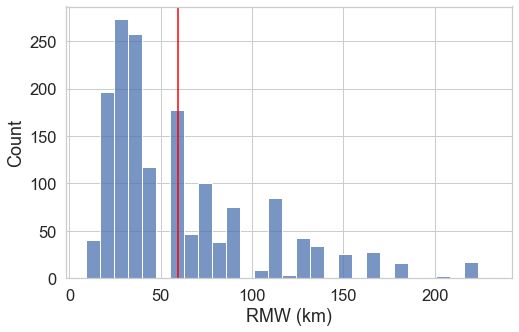

In [12]:
sns.histplot(x=data_atcf['rmw'])
plt.axvline(x=rmw_climatology,color='red')
plt.xlabel('RMW (km)')


# Linear Baseline Model

In [13]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler

In [14]:
predictors_basic = ['lat', 'lon', 'wind', 'pressure_min', 'distance']
predictors_rad = ['lat', 'lon', 'wind', 'pressure_min', 'distance', 'rad_pc_1', 'rad_pc_2', 'rad_pc_3']
predictors_size = ['lat', 'lon', 'wind', 'pressure_min', 'distance', 'size_pc_1', 'size_pc_2', 'size_pc_3']
predictors_full = ['lat', 'lon', 'wind', 'pressure_min', 'distance', 'rad_pc_1', 'rad_pc_2', 'rad_pc_3', 'size_pc_1', 'size_pc_2', 'size_pc_3']

In [35]:
predictors = predictors_basic
target = ['rmw']
scaler = StandardScaler().fit(train_data[predictors])

X_train = scaler.transform(train_data[predictors])
y_train = train_data[target].to_numpy().reshape(-1)
X_test = scaler.transform(test_data[predictors])
y_test = test_data[target].to_numpy().reshape(-1)

lm = LinearRegression().fit(X_train, y_train)

(0.0, 140.0)

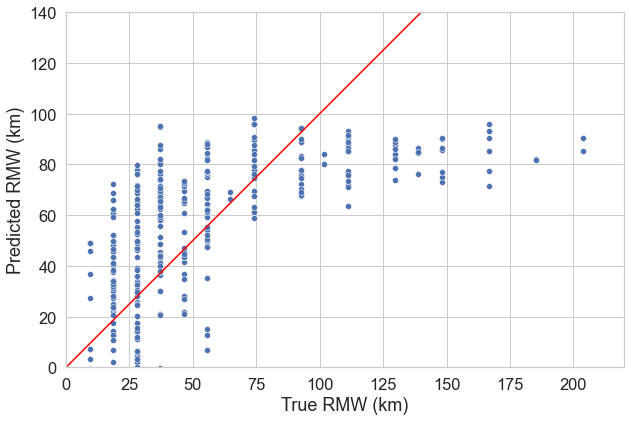

In [36]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [10, 10]})
sns.scatterplot(y = lm.predict(X_test), x = y_test)
plt.ylabel('Predicted RMW (km)')
plt.xlabel('True RMW (km)')
plt.plot([0, 140], [0, 140], color = 'red')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim(0, 220)
ax.set_ylim(0, 140)

In [18]:
linear = {
    'mae': mean_absolute_error(y_test, lm.predict(X_test)),
    'rmse': mean_squared_error(y_test, lm.predict(X_test), squared=False)
}
print(linear)
# BASIC

{'mae': 25.2438827348644, 'rmse': 32.284763228369414}


In [22]:
linear = {
    'mae': mean_absolute_error(y_test, lm.predict(X_test)),
    'rmse': mean_squared_error(y_test, lm.predict(X_test), squared=False)
}
print(linear)
# SIZE

{'mae': 24.16394707105237, 'rmse': 31.29470770059516}


In [24]:
linear = {
    'mae': mean_absolute_error(y_test, lm.predict(X_test)),
    'rmse': mean_squared_error(y_test, lm.predict(X_test), squared=False)
}
print(linear)
# RAD

{'mae': 20.193912885165116, 'rmse': 26.690935543177137}


In [26]:
linear = {
    'mae': mean_absolute_error(y_test, lm.predict(X_test)),
    'rmse': mean_squared_error(y_test, lm.predict(X_test), squared=False)
}
print(linear)
# ALL

{'mae': 18.971876450118835, 'rmse': 26.011951072480592}


In [61]:
print(f'intercept: {round(lm.intercept_, 4)}')
for x, y in zip(predictors, lm.coef_):
    print(f'{x}: {round(y, 4)}')

intercept: 56.2755
lat: 5.679
lon: -5.2868
wind: -39.2258
pressure_min: -21.0367
distance: -1.4139


In [25]:
lasso = LassoCV(cv = 5, n_alphas=1000, n_jobs=-1).fit(X_train, y_train)

In [26]:
lasso_eval = {
    'mae': mean_absolute_error(y_test, lasso.predict(X_test)),
    'rmse': mean_squared_error(y_test, lasso.predict(X_test), squared=False)
}
print(lasso_eval)

{'mae': 16.6462069820844, 'rmse': 23.087820791322205}


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [95]:
param_grid = {'min_samples_leaf': np.arange(1, 25, 3)}
rf = GridSearchCV(RandomForestRegressor(), param_grid, scoring = 'neg_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
rf.best_params_

{'min_samples_leaf': 19}

(0.0, 220.0)

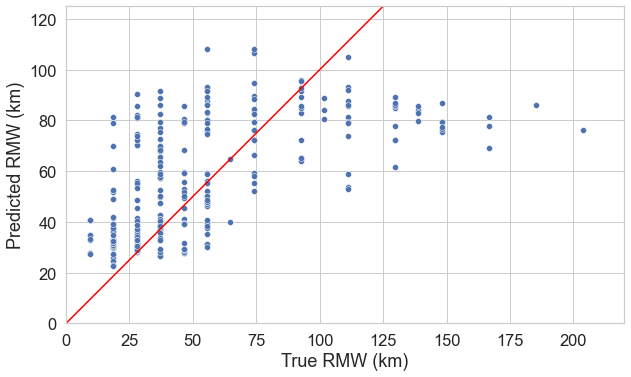

In [98]:
sns.set(style='whitegrid', palette="deep", font_scale=1.5, rc={"figure.figsize": [10, 10]})
sns.scatterplot(y = rf.predict(X_test), x = y_test)
plt.ylabel('Predicted RMW (km)')
plt.xlabel('True RMW (km)')
plt.plot([0, 125], [0, 125], color = 'red')
ax = plt.gca()
ax.set_aspect(1)
ax.set_ylim(0, 125)
ax.set_xlim(0, 220)

In [57]:
rf_eval = {
    'mae': mean_absolute_error(y_test, rf.predict(X_test)),
    'rmse': mean_squared_error(y_test, rf.predict(X_test), squared=False)
}
print(rf_eval)
# BASIC

{'mae': 20.99363938285499, 'rmse': 29.69183517739473}


In [33]:
rf_eval = {
    'mae': mean_absolute_error(y_test, rf.predict(X_test)),
    'rmse': mean_squared_error(y_test, rf.predict(X_test), squared=False)
}
print(rf_eval)
# SIZE

{'mae': 20.01192048605491, 'rmse': 27.217915939257818}


In [36]:
rf_eval = {
    'mae': mean_absolute_error(y_test, rf.predict(X_test)),
    'rmse': mean_squared_error(y_test, rf.predict(X_test), squared=False)
}
print(rf_eval)
# RAD

{'mae': 16.965309764937082, 'rmse': 23.78141055607724}


In [68]:
rf_eval = {
    'mae': mean_absolute_error(y_test, rf.predict(X_test)),
    'rmse': mean_squared_error(y_test, rf.predict(X_test), squared=False)
}
print(rf_eval)
# ALL

{'mae': 16.42881512870436, 'rmse': 23.340040054470357}
